<a href="https://colab.research.google.com/github/ridhimapm/CIS5930-Programming-Project-SVM-/blob/main/svm_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is Question 1b.
Running the Implementation on random data generated in the following way: For class A which corresponds to +1, generate 200 points, where according to a two dimensional gaussian with mean (-1,-1) and covariance matrix of (1,0.25) and (0.25,1) For class B, that corresponds to -1, generate 200 points using same distribution. The mean in this case will be (1,1) Seed the random number generator with The last 5 digits of FSU lib# : 47405

In [3]:
#Importing necessary libraries
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import random
from sklearn.model_selection import LeaveOneOut

In [4]:
# linear kernel is the original form of the kernel.
def linear_kernel(x1, x2):
  return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
  return (1 + np.dot(x, y)) ** p
  
def gaussian_kernel(x, y, sigma=5.0):
  return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [5]:
#Starting with the SVM Object.
class SVM(object):
  #the initialization method just simply sets the kernel, sets C's default to NONE, when C is set to NONE it's a hard margin SVM
  #But we want to implement a SOFT-MARGIN SVM, for that we need to set C to some value, 
  #we set C to something we want our penalty parameter to be
  def __init__(self, kernel=linear_kernel, C=0.01):
    self.kernel = kernel
    self.C = C
    if self.C is not None: self.C = float(self.C)

  def fit(self, X, y):
    n_samples, n_features = X.shape

    # Gram matrix (creates all the values for the quadratic programming solver)
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
      for j in range(n_samples):
        K[i,j] = self.kernel(X[i], X[j])

    P = cvxopt.matrix(np.outer(y,y) * K)  
    q = cvxopt.matrix(np.ones(n_samples) * -1)
    A = cvxopt.matrix(y, (1,n_samples))
    b = cvxopt.matrix(0.0)

    if self.C is None:
      G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
      h = cvxopt.matrix(np.zeros(n_samples))

    else:
      tmp1 = np.diag(np.ones(n_samples) * -1)
      tmp2 = np.identity(n_samples)
      G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
      tmp1 = np.zeros(n_samples)
      tmp2 = np.ones(n_samples) * self.C
      h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

      # solve QP problem
      solution = cvxopt.solvers.qp(P, q, G, h, A, b)
      
      # Lagrange multipliers
      a = np.ravel(solution['x'])  

      # Support vectors have non zero lagrange multipliers
      sv = a > 1e-5
      ind = np.arange(len(a))[sv]
      self.a = a[sv]
      self.sv = X[sv]
      self.sv_y = y[sv]
      print('{0} support vectors out of {1} points'.format(len(self.a), n_samples))


      # Intercept
      self.b = 0
      for n in range(len(self.a)):
        self.b += self.sv_y[n]
        self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
      self.b /= len(self.a)

      # Weight vector
      if self.kernel == linear_kernel:
          self.w = np.zeros(n_features)
          for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]

      else:
           self.w = None  

  def project(self, X):
      if self.w is not None:
           return np.dot(X, self.w) + self.b               

      else:
           y_predict = np.zeros(len(X))
           for i in range(len(X)):
             s = 0
             for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
               s += a * sv_y * self.kernel(X[i], sv)
             y_predict[i] = s
      return y_predict + self.b  
  
  def predict(self, X):
      return np.sign(self.project(X))


     pcost       dcost       gap    pres   dres
 0: -3.3576e+01 -3.6275e+01  1e+03  3e+01  3e-15
 1: -5.8770e+00 -3.3739e+01  8e+01  1e+00  3e-15
 2: -3.8808e+00 -1.5305e+01  1e+01  1e-01  9e-16
 3: -4.1341e+00 -5.8543e+00  2e+00  1e-02  1e-15
 4: -4.5714e+00 -5.0855e+00  6e-01  3e-03  6e-16
 5: -4.7135e+00 -4.8525e+00  1e-01  4e-04  6e-16
 6: -4.7645e+00 -4.7732e+00  9e-03  6e-06  6e-16
 7: -4.7681e+00 -4.7703e+00  2e-03  9e-07  5e-16
 8: -4.7691e+00 -4.7693e+00  3e-04  3e-08  5e-16
 9: -4.7692e+00 -4.7692e+00  6e-06  7e-10  6e-16
10: -4.7692e+00 -4.7692e+00  8e-08  8e-12  6e-16
Optimal solution found.
57 support vectors out of 180 points
202 out of 220 predictions correct


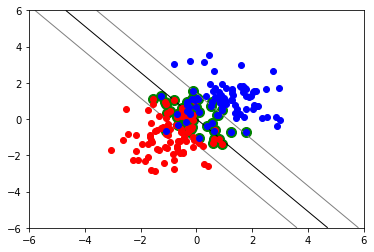

In [6]:
if __name__ == "__main__":
  import matplotlib.pyplot as pl

  def gen_lin_separable_overlap_data():
    
    # generate training data in the 2-d case
      np.random.seed(47405)
      mean1 = np.array([-1, -1])
      mean2 = np.array([1, 1])
      cov = np.array([[1, 0.25], [0.25, 1]])
      X1 = np.random.multivariate_normal(mean1, cov, 200)
      y1 = np.ones(len(X1))
      X2 = np.random.multivariate_normal(mean2, cov, 200)
      y2 = np.ones(len(X2)) * -1
      return X1, y1, X2, y2

  def split_train(X1, y1, X2, y2):
      X1_train = X1[:90]
      y1_train = y1[:90]
      X2_train = X2[:90]
      y2_train = y2[:90]
      X_train = np.vstack((X1_train, X2_train))
      y_train = np.hstack((y1_train, y2_train))
      return X_train, y_train

  def split_test(X1, y1, X2, y2):
      X1_test = X1[90:]
      y1_test = y1[90:]
      X2_test = X2[90:]
      y2_test = y2[90:]
      X_test = np.vstack((X1_test, X2_test))
      y_test = np.hstack((y1_test, y2_test))
      return X_test, y_test    

  def plot_margin(X1_train, X2_train, clf):
      def f(x, w, b, c=0):
        # given x, return y such that [x,y] in on the line
        # w.x + b = c
          return (-w[0] * x - b + c) / w[1]            

      pl.plot(X1_train[:,0], X1_train[:,1], "ro")
      pl.plot(X2_train[:,0], X2_train[:,1], "bo")
      pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")
      
      # w.x + b = 0
      a0 = -4; a1 = f(a0, clf.w, clf.b)
      b0 = 4; b1 = f(b0, clf.w, clf.b)
      pl.plot([a0,b0], [a1,b1], "k")
      
      # w.x + b = 1
      a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
      b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
      pl.plot([a0,b0], [a1,b1], "k--")

      # w.x + b = -1
      a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
      b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
      pl.plot([a0,b0], [a1,b1], "k--")
      
      pl.axis("tight")
      pl.show()


  def plot_contour(X1_train, X2_train, clf):
      pl.plot(X1_train[:,0], X1_train[:,1], "ro")
      pl.plot(X2_train[:,0], X2_train[:,1], "bo")
      pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

      X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
      X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
      Z = clf.project(X).reshape(X1.shape)
      pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
      pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
      pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

      pl.axis("tight")
      pl.show()

  def test_soft():
      X1, y1, X2, y2 = gen_lin_separable_overlap_data()
      X_train, y_train = split_train(X1, y1, X2, y2)
      X_test, y_test = split_test(X1, y1, X2, y2)

      clf = SVM(C=0.1)
      clf.fit(X_train, y_train)
      y_predict = clf.predict(X_test)
      correct = np.sum(y_predict == y_test)
      print('{0} out of {1} predictions correct'.format(correct, len(y_predict)))
      plot_contour(X_train[y_train==1], X_train[y_train==-1], clf)       


  test_soft() 

Different C values were checked and the screenshots are attached in the Report.

Leave-one-out cross validation error

In [8]:
#Leave-one-out cross validation error
X = np.array([[1, 2], [3, 4]])
y = np.array([1, 2])
loo = LeaveOneOut()
loo.get_n_splits(X)
print(loo)
LeaveOneOut()

for train_index, test_index in loo.split(X):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  print(X_train, X_test, y_train, y_test)

LeaveOneOut()
TRAIN: [1] TEST: [0]
[[3 4]] [[1 2]] [2] [1]
TRAIN: [0] TEST: [1]
[[1 2]] [[3 4]] [1] [2]
